In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
base = "drive/My Drive/외부/공모전/[기상] AI프렌즈 시즌1 온도 추정 경진대회/"

data = pd.read_csv(os.path.join(base, "train.csv"))

### 똑같은 값만 나오는 센서 삭제

In [4]:
broken_cols = data.columns[data.max() == data.min()]
print(broken_cols)

for col in broken_cols:
  data = data.drop(columns=col)

Index(['X14', 'X16', 'X19'], dtype='object')


In [0]:
data['hour'] = (data.index % 144 / 6).astype('int')
data['minute'] = (data.index % 144 % 6).astype('int')

In [6]:
display(data)

id   X00    X01  X02  X03  X04  ...  Y15  Y16  Y17   Y18       hour  minute
0        0   9.7  988.8  1.2  0.6  0.0  ...  9.0  8.0  9.0   NaN   0.000000       0
1        1   9.3  988.9  1.7  1.9  0.0  ...  9.0  7.5  9.0   NaN   0.166667       1
2        2   9.4  989.0  1.1  2.3  0.0  ...  8.5  7.5  8.5   NaN   0.333333       2
3        3   9.4  988.9  1.5  0.7  0.0  ...  8.5  7.5  8.5   NaN   0.500000       3
4        4   9.2  988.9  0.8  1.7  0.0  ...  8.5  7.5  8.5   NaN   0.666667       4
...    ...   ...    ...  ...  ...  ...  ...  ...  ...  ...   ...        ...     ...
4747  4747  19.9  987.6  0.9  0.8  0.0  ...  NaN  NaN  NaN  21.5  23.166667       1
4748  4748  19.9  987.6  0.5  0.7  0.0  ...  NaN  NaN  NaN  21.5  23.333333       2
4749  4749  19.7  987.7  0.9  0.6  0.0  ...  NaN  NaN  NaN  21.5  23.500000       3
4750  4750  19.4  987.7  0.9  0.8  0.0  ...  NaN  NaN  NaN  21.5  23.666667       4
4751  4751  19.1  987.6  1.0  0.3  0.0  ...  NaN  NaN  NaN  21.0  23.833333       5

[4752 rows x 59 columns]

In [0]:
X_cols = ['hour', 'minute'] + [col for col in data.columns if 'X' in col]
Y_cols = ["Y{0:02}".format(i) for i in range(18)]

train = data[:4320]
val = data[4320:]

### 센서 데이터 시각화

In [0]:
sensors = {
  'temperature' : ["X00","X07","X28","X31","X32"], #기온
  'localpress'  : ["X01","X06","X22","X27","X29"], #현지기압
  'speed'       : ["X02","X03","X18","X24","X26"], #풍속
  'water'       : ["X04","X10","X21","X36","X39"], #일일 누적강수량
  'press'       : ["X05","X08","X09","X23","X33"], #해면기압
  'sun'         : ["X11","X34"], #일일 누적일사량
  'humidity'    : ["X12","X20","X30","X37","X38"], #습도
  'direction'   : ["X13","X15","X17","X25","X35"], #풍향
}

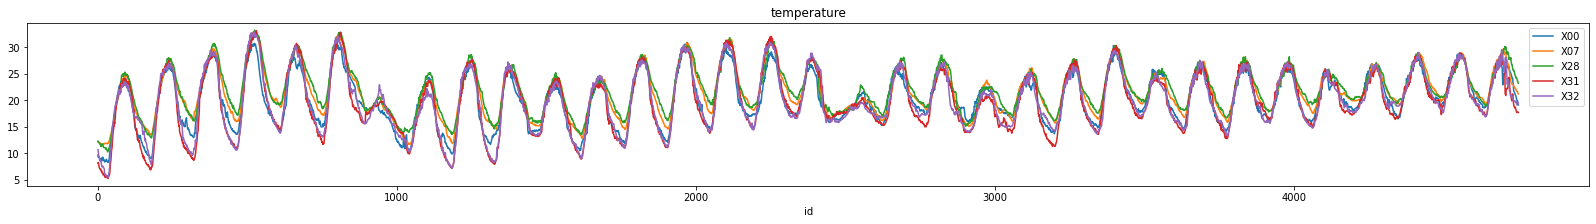

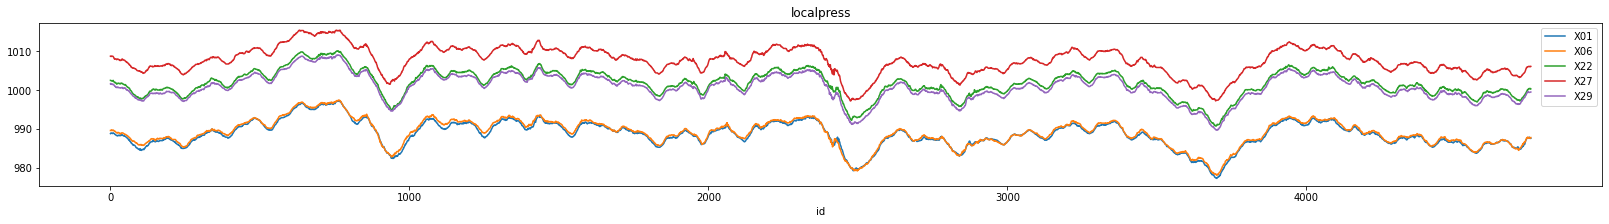

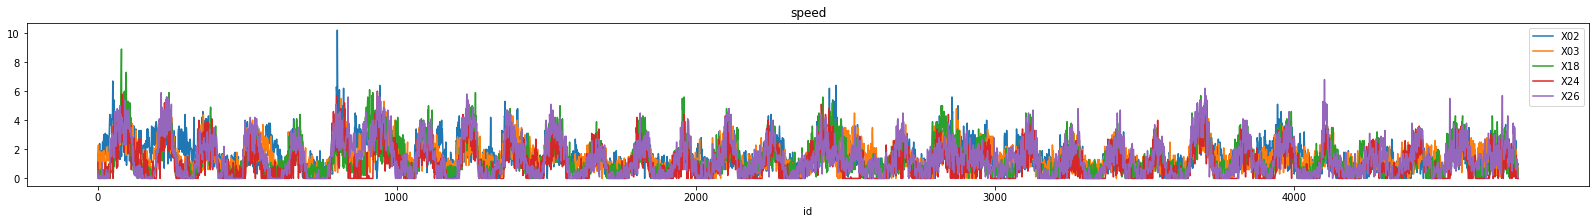

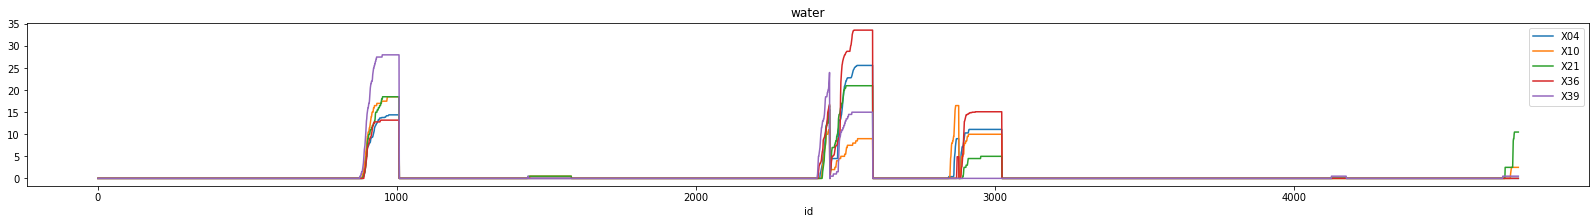

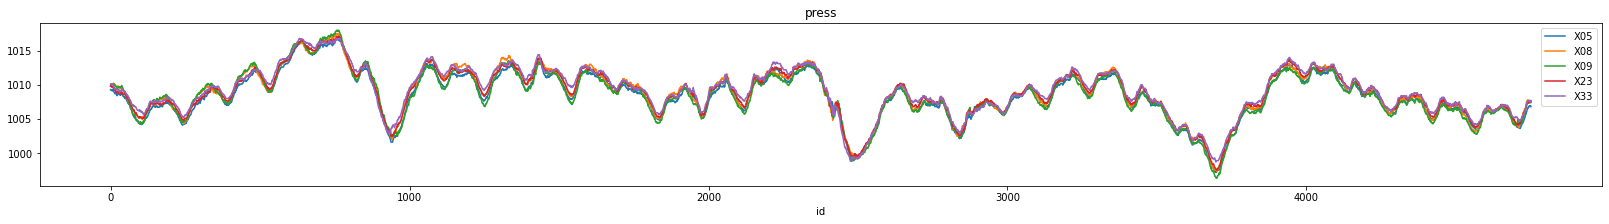

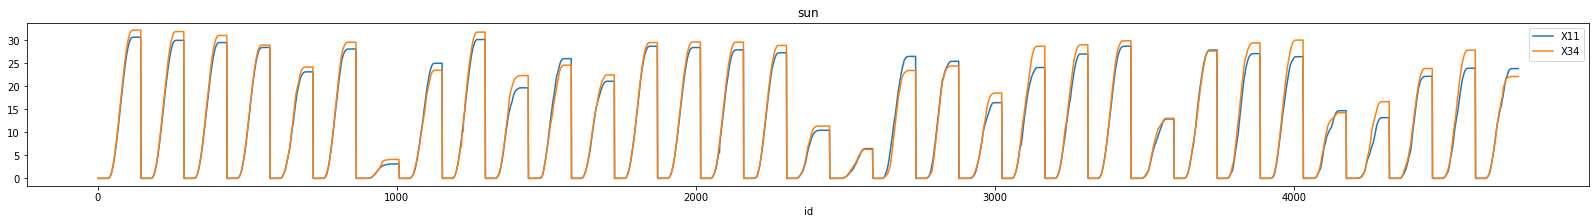

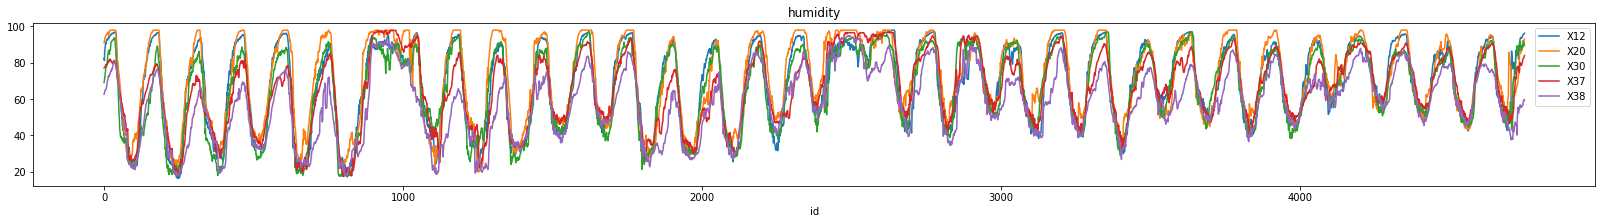

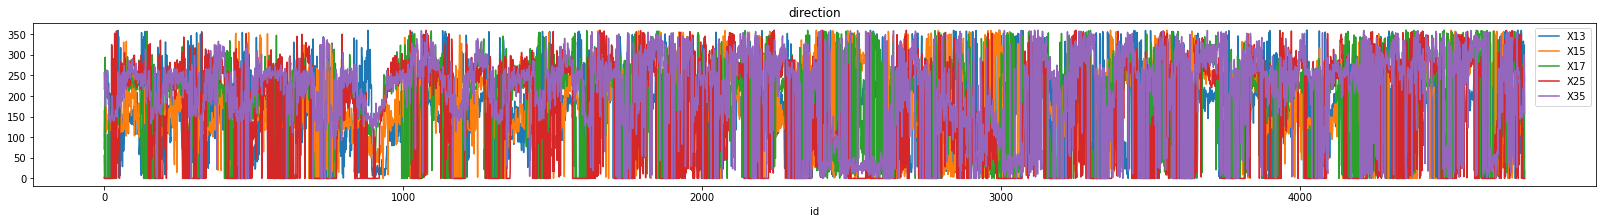

In [9]:
for name, cols in sensors.items():
  data.plot(x='id', y=cols, figsize=(28,3), title=name)

### Feature Selection

In [0]:
def forward_selection(clf, dataset, X_cols, Y_col='Y18'):
  sfs = SFS(clf, 
            k_features=len(X_cols), 
            forward=True, 
            floating=False, 
            scoring='neg_mean_squared_error',
            cv=10)

  sfs = sfs.fit(dataset[X_cols], dataset[Y_col])
  fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
  plt.title('Sequential Forward Selection (w. StdErr)')
  plt.grid()
  plt.show()

  return sfs

def print_good_features(sfs, cnt=1):
  metric = sfs.get_metric_dict()
  avg_scores = dict()
  max_key = None

  for key in metric.keys():
    avg_scores[metric[key]['feature_names']] = metric[key]['avg_score']

  for key, score in sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:cnt+ 1]:
    if max_key is None: max_key = key
    
    print("feature_names: {}, avg_score: {}".format(key, score))

    return max_key

def check_cross_val_score(clf, dataset, X_cols, Y_col='Y18', cv=5):
  scores = cross_val_score(clf, val[X_cols], val[Y_col], cv=cv)

  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Y00


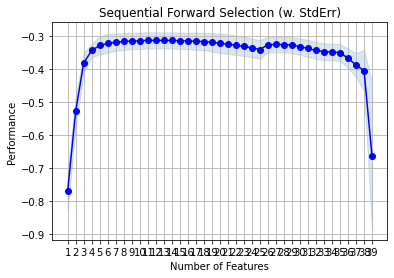

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X07', 'X15', 'X18', 'X28', 'X30', 'X34', 'X38', 'X39'), avg_score: -0.3141777880747216
Y01


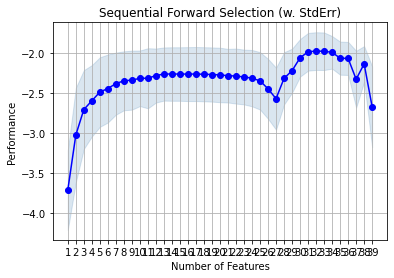

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38'), avg_score: -1.9798853498848317
Y02


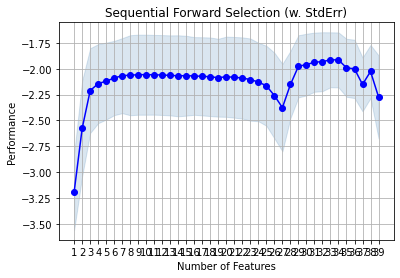

feature_names: ('hour', 'minute', 'X00', 'X01', 'X02', 'X03', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38', 'X39'), avg_score: -1.9128760723589096
Y03


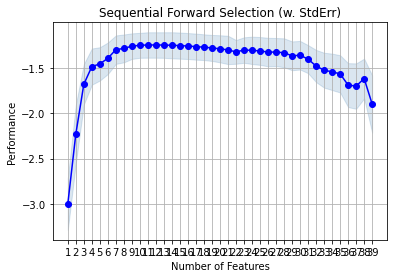

feature_names: ('hour', 'minute', 'X00', 'X03', 'X07', 'X20', 'X25', 'X28', 'X30', 'X34', 'X35', 'X39'), avg_score: -1.2492241371653106
Y04


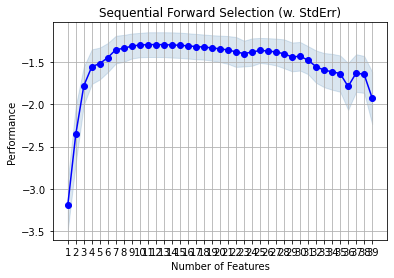

feature_names: ('hour', 'X00', 'X03', 'X07', 'X20', 'X25', 'X28', 'X30', 'X34', 'X35', 'X39'), avg_score: -1.2912848043716867
Y05


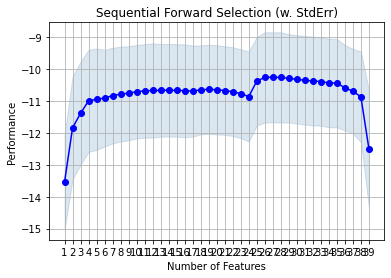

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X08', 'X09', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X24', 'X25', 'X26', 'X28', 'X30', 'X31', 'X32', 'X33', 'X35', 'X37', 'X38', 'X39'), avg_score: -10.249396540373041
Y06


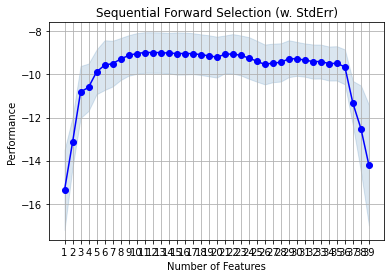

feature_names: ('hour', 'X10', 'X12', 'X15', 'X18', 'X20', 'X21', 'X25', 'X32', 'X34', 'X38'), avg_score: -8.98371589824286
Y07


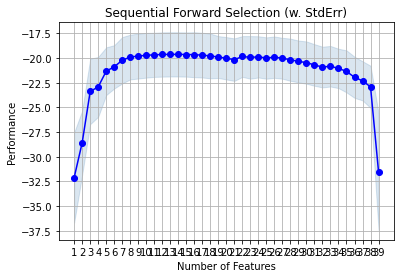

feature_names: ('hour', 'X03', 'X12', 'X15', 'X17', 'X18', 'X24', 'X28', 'X32', 'X34', 'X35', 'X37', 'X39'), avg_score: -19.62508255352777
Y08


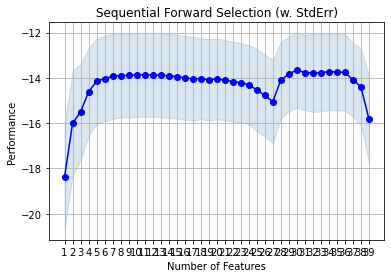

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X04', 'X06', 'X07', 'X08', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X24', 'X25', 'X26', 'X27', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38'), avg_score: -13.649518799791139
Y09


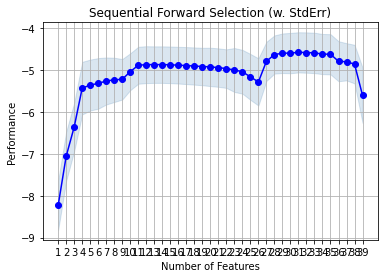

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X05', 'X06', 'X07', 'X08', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38', 'X39'), avg_score: -4.577463884288653
Y10


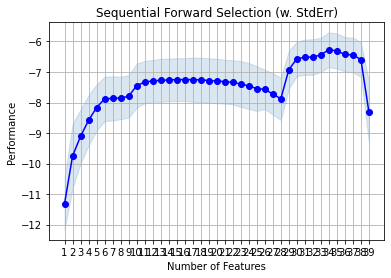

feature_names: ('hour', 'minute', 'X00', 'X01', 'X02', 'X03', 'X04', 'X06', 'X07', 'X08', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'), avg_score: -6.265807247272507
Y11


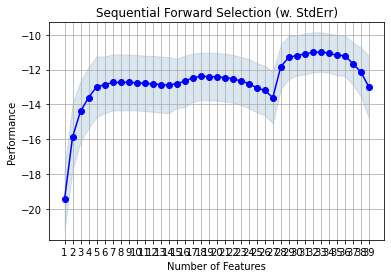

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X04', 'X06', 'X07', 'X08', 'X09', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X35', 'X36', 'X37', 'X38', 'X39'), avg_score: -10.992259778090574
Y12


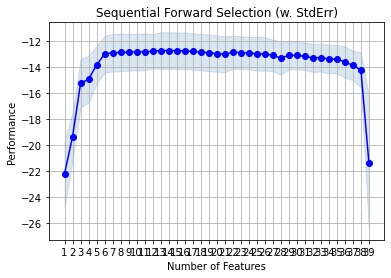

feature_names: ('hour', 'X12', 'X13', 'X17', 'X18', 'X20', 'X24', 'X32', 'X34', 'X36', 'X37', 'X38', 'X39'), avg_score: -12.75358221096536
Y13


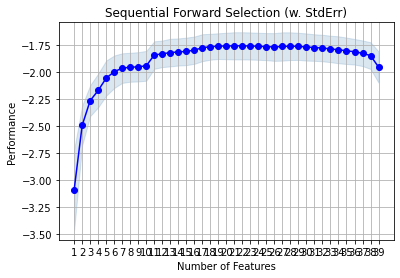

feature_names: ('hour', 'X00', 'X01', 'X02', 'X06', 'X07', 'X09', 'X12', 'X15', 'X17', 'X18', 'X20', 'X23', 'X24', 'X25', 'X26', 'X29', 'X31', 'X33', 'X36', 'X39'), avg_score: -1.754625000743363
Y14


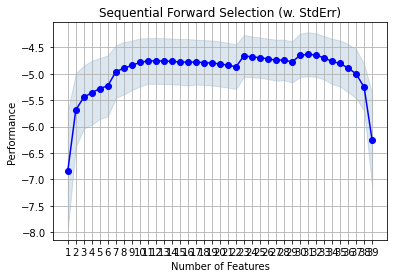

feature_names: ('hour', 'minute', 'X00', 'X01', 'X02', 'X03', 'X05', 'X06', 'X07', 'X08', 'X09', 'X12', 'X13', 'X15', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X28', 'X29', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X38', 'X39'), avg_score: -4.628701292366769
Y15


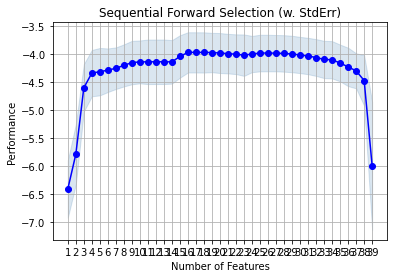

feature_names: ('hour', 'minute', 'X03', 'X06', 'X07', 'X15', 'X18', 'X20', 'X24', 'X28', 'X29', 'X31', 'X32', 'X33', 'X34', 'X39'), avg_score: -3.9736851334260876
Y16


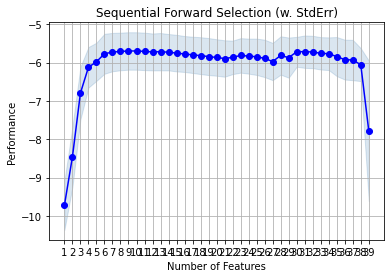

feature_names: ('hour', 'X00', 'X12', 'X13', 'X21', 'X30', 'X31', 'X32', 'X34'), avg_score: -5.695436965809948
Y17


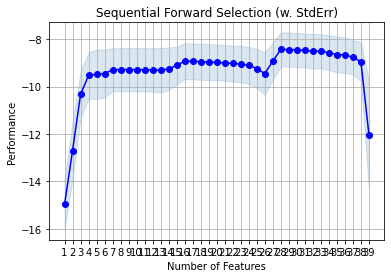

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X08', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X24', 'X25', 'X26', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'), avg_score: -8.429460517577061


In [19]:
ridge_feature = list()

for Y_col in Y_cols:
  print(Y_col)
  sfs = forward_selection(Ridge(alpha=1.0), train, X_cols, Y_col)
  features = print_good_features(sfs)

  ridge_feature.append(features)

- 5,6,7,8,11, 12

In [21]:
temp_train = train.copy()

for Y_col, feature in zip(Y_cols, ridge_feature):
  feature = list(feature)

  ridge = Ridge(alpha=1.0)
  ridge.fit(train[feature], train[Y_col])

  val[Y_col] = ridge.predict(val[feature])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

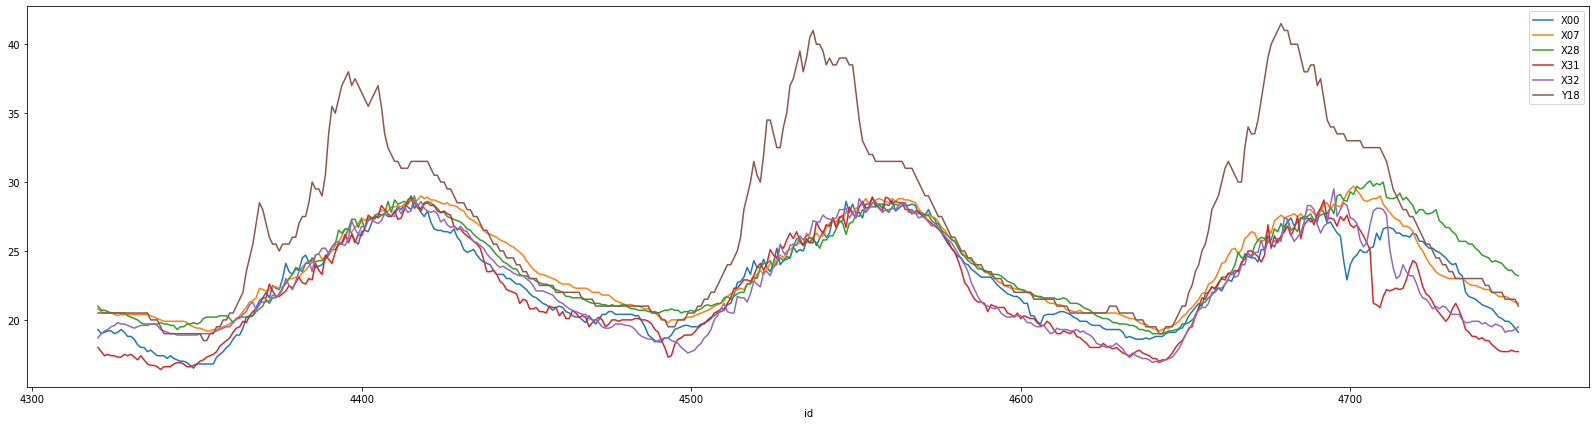

In [22]:
val.plot(x='id', y=sensors['temperature'] + ['Y18'], figsize=(28,7))

In [0]:
Y_val = val[['id'] + Y_cols + ['Y18']]

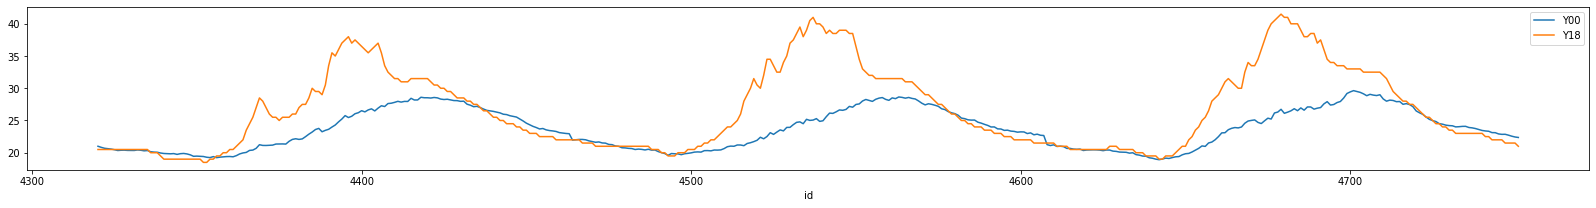

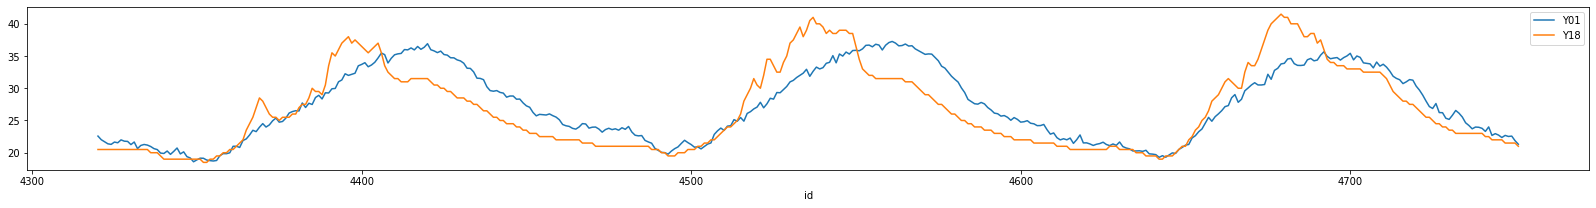

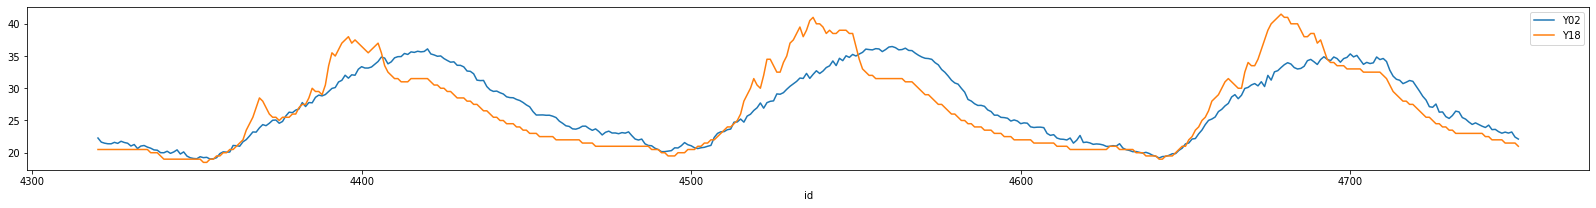

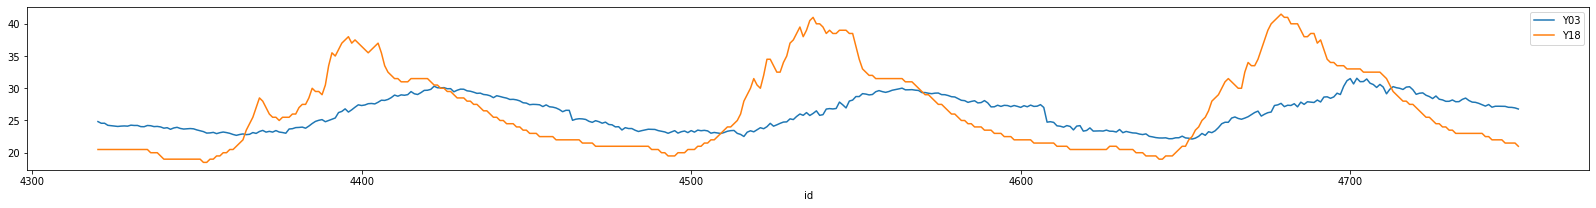

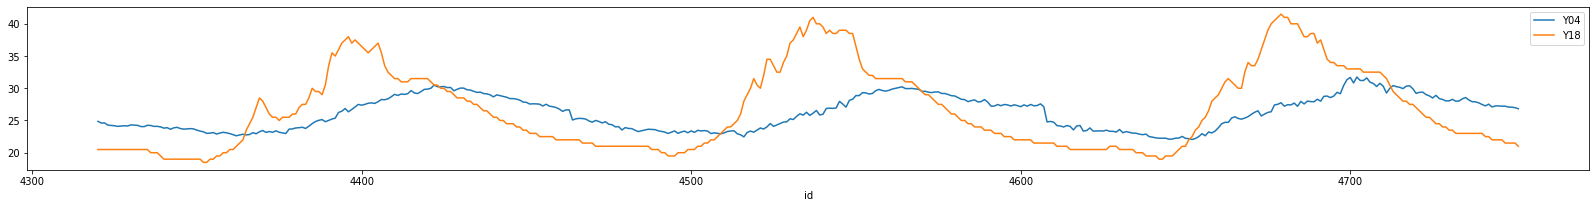

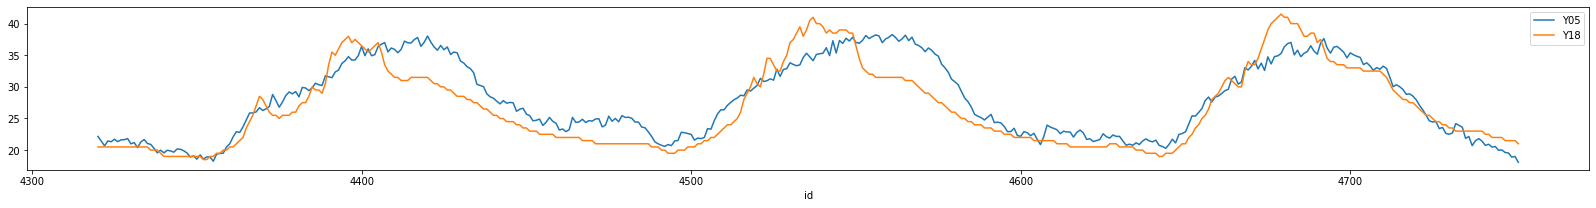

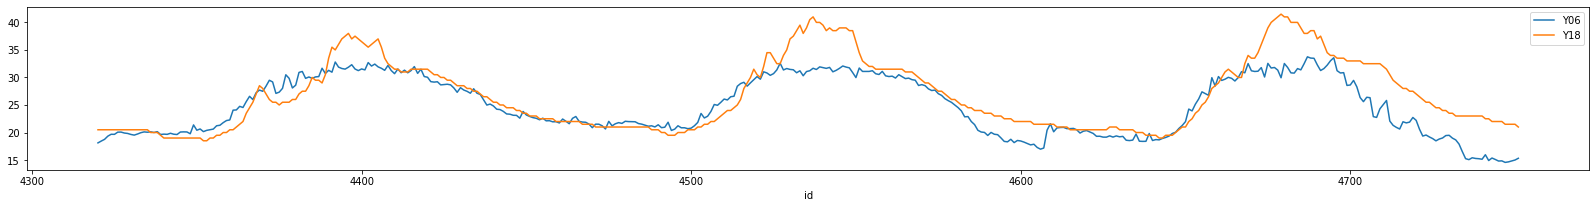

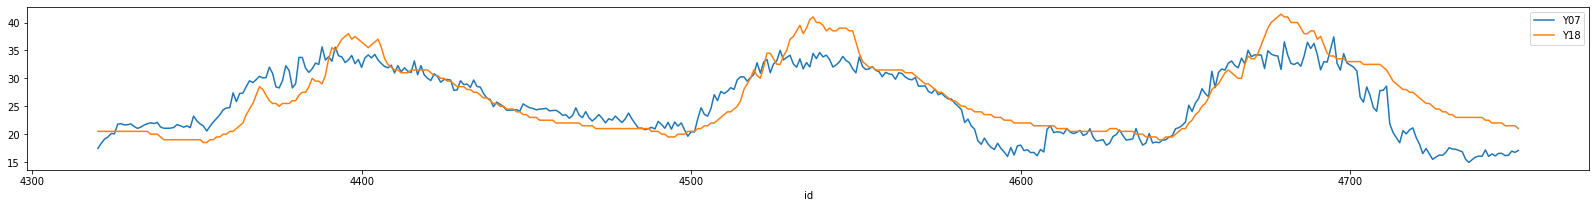

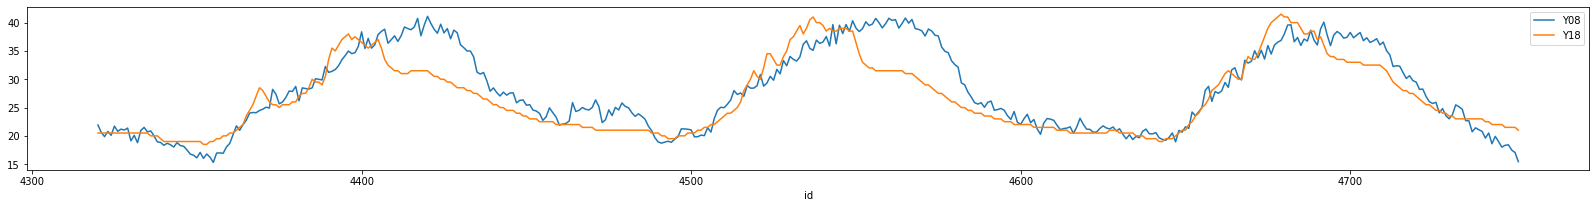

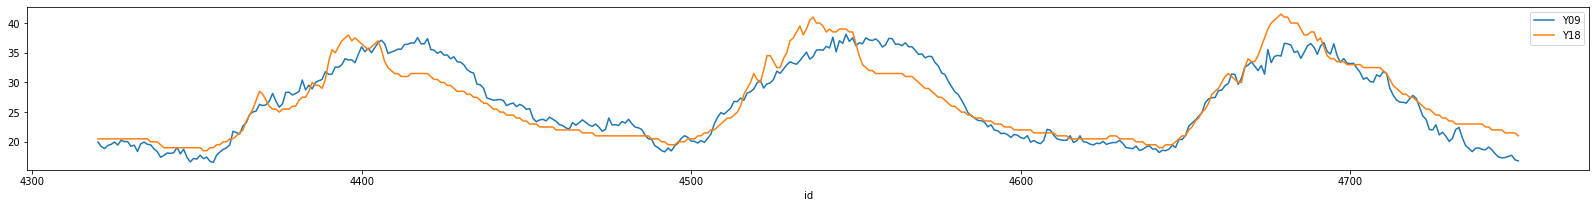

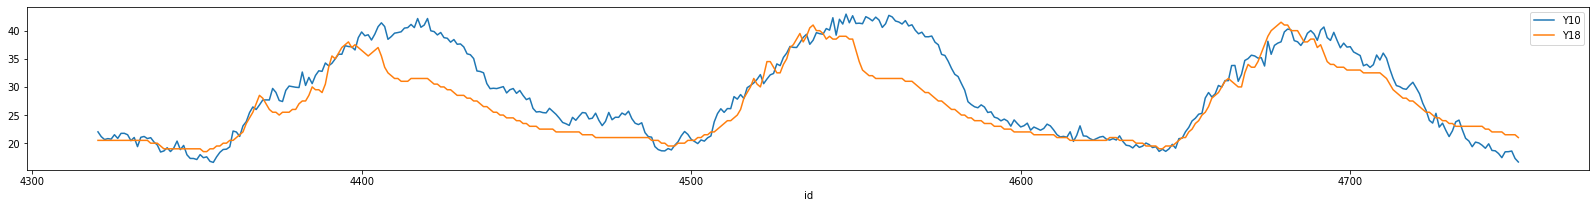

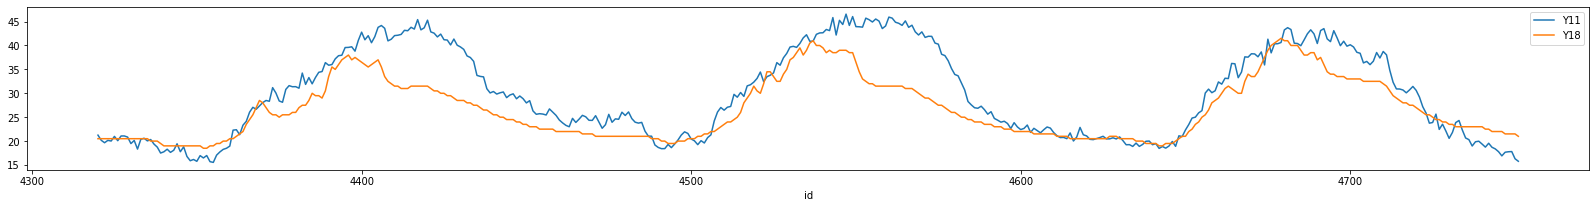

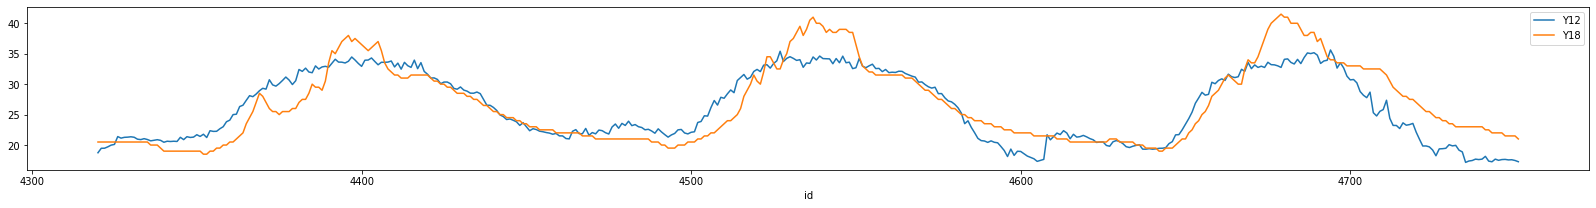

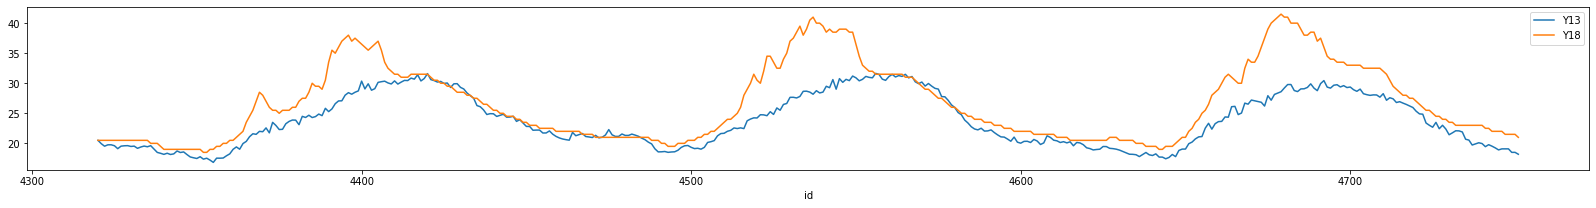

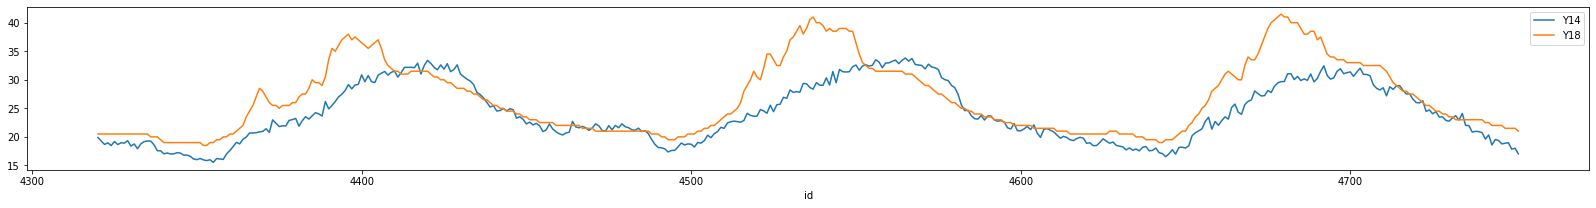

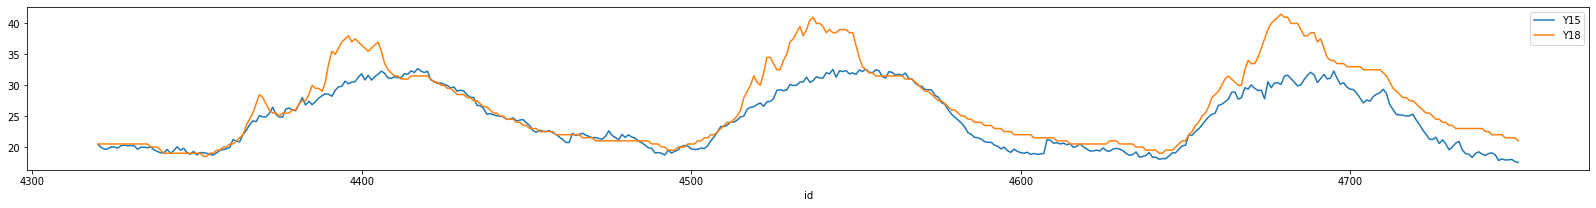

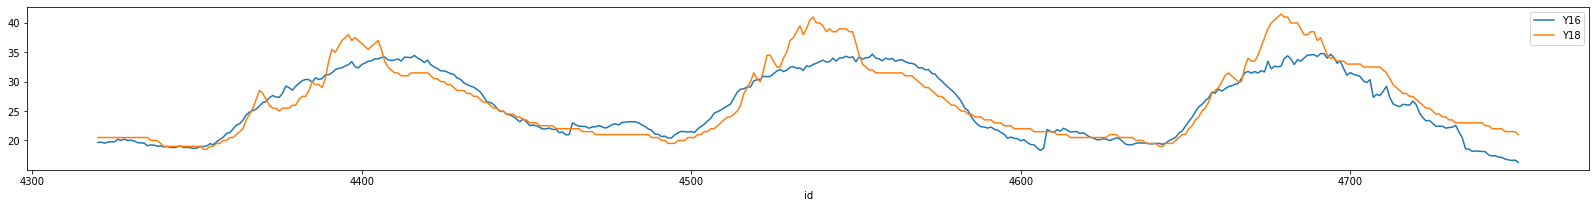

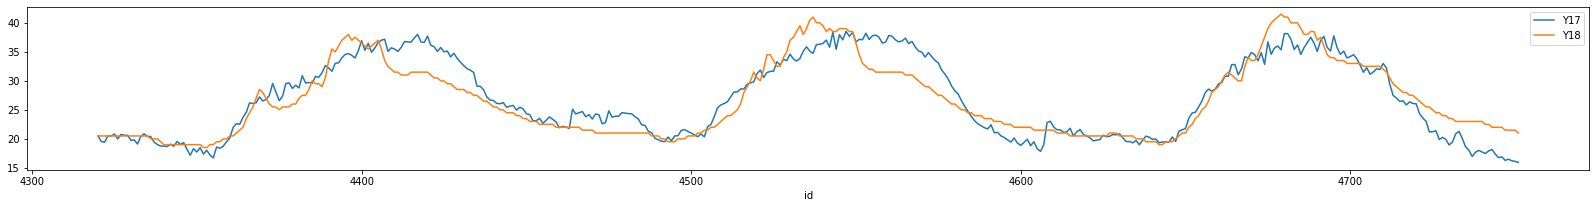

In [24]:
for Y_col in Y_cols:
  Y_val.plot(x='id', y=[Y_col] + ['Y18'], figsize=(28,3))

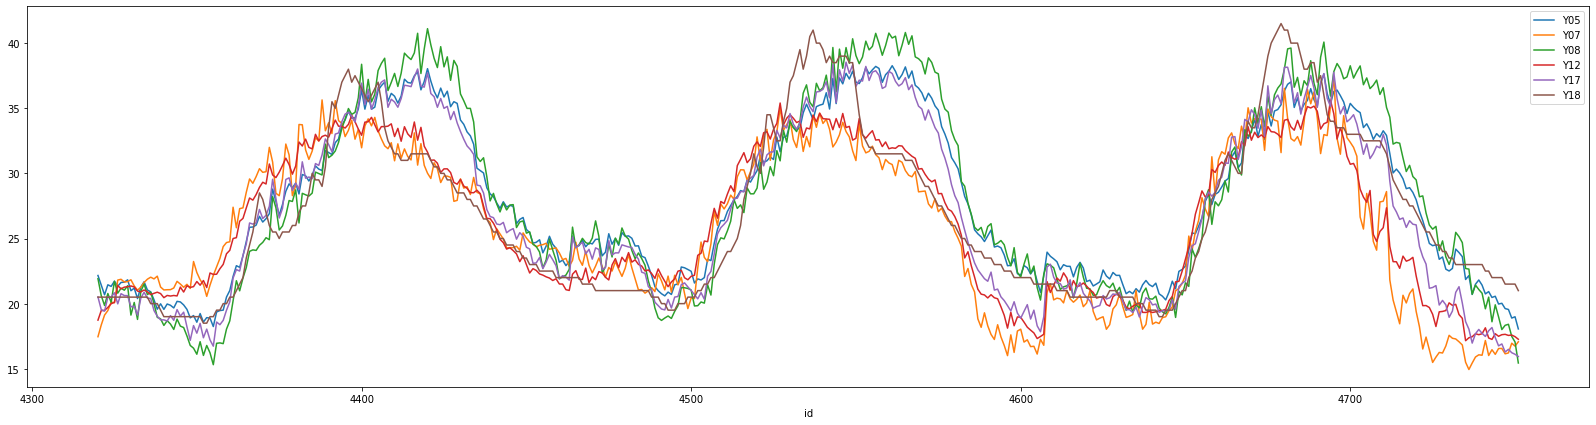

In [25]:
Y_val.plot(x='id', y=['Y05', 'Y07', 'Y08', 'Y12', 'Y17', 'Y18'], figsize=(28,7))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


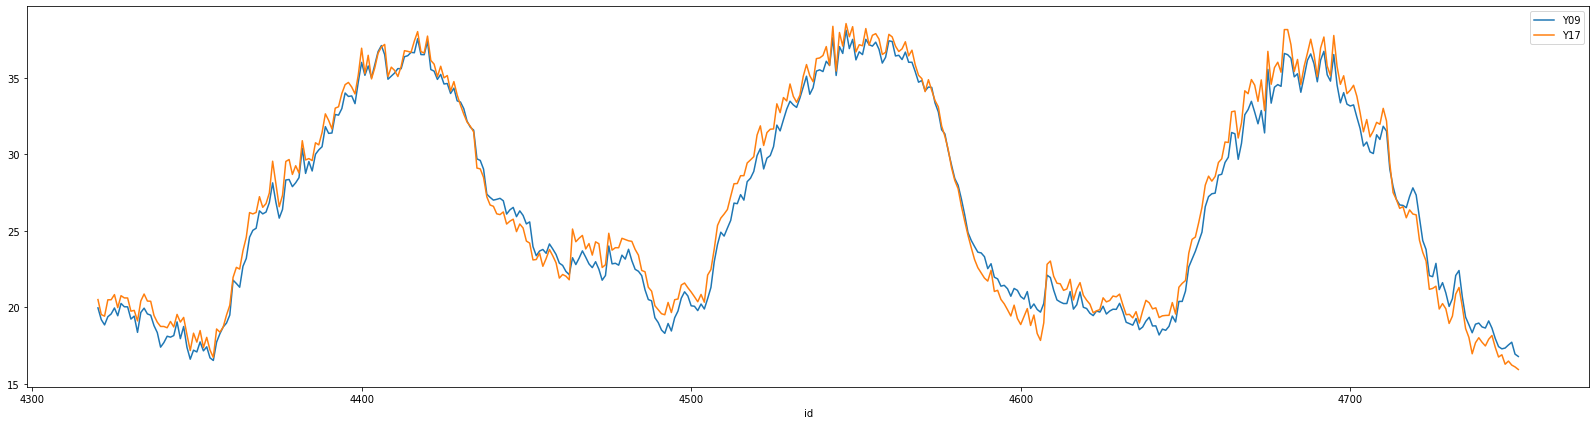

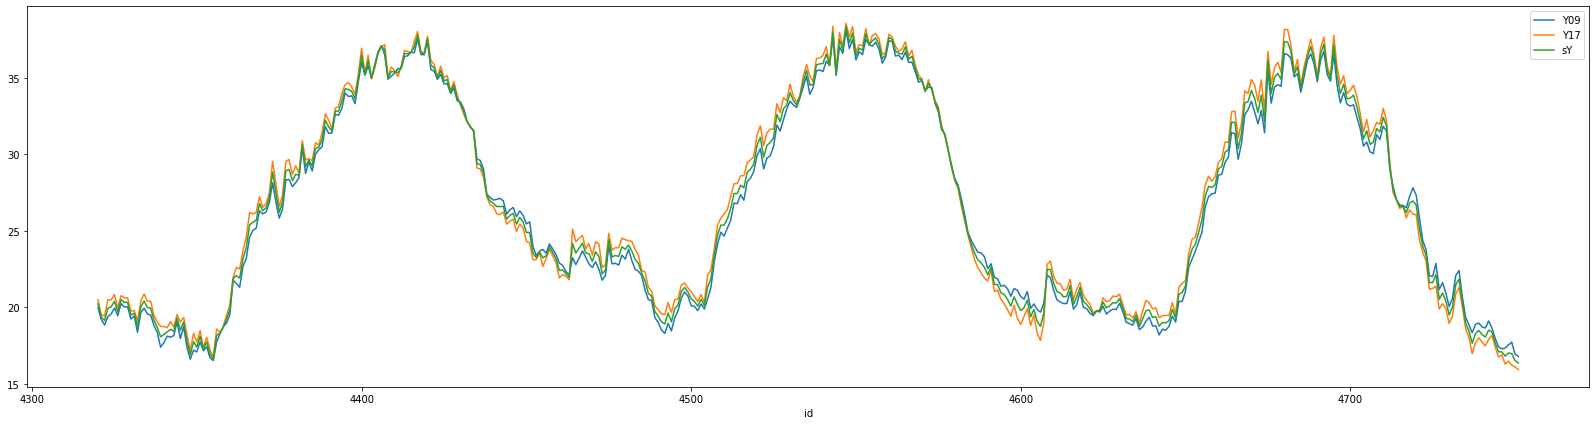

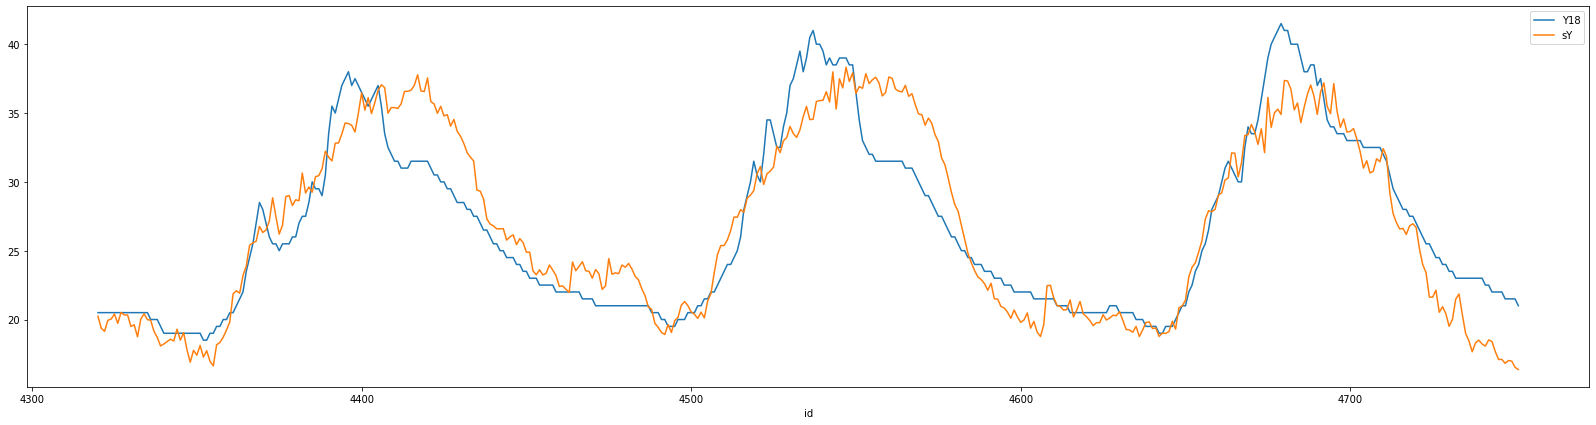

In [41]:
Y_val['sY'] = Y_val[['Y09', 'Y17']].mean(axis=1)

Y_val.plot(x='id', y=['Y09', 'Y17'], figsize=(28,7))
Y_val.plot(x='id', y=['Y09', 'Y17', 'sY'], figsize=(28,7))
Y_val.plot(x='id', y=['Y18', 'sY'], figsize=(28,7))

In [26]:
Y_val['tY'] = Y_val[Y_cols].mean(axis=1)
Y_val['hY'] = Y_val[['Y05', 'Y07', 'Y08', 'Y12', 'Y17']].mean(axis=1)
Y_val['nY'] = Y_val[['Y09', 'Y15']].mean(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

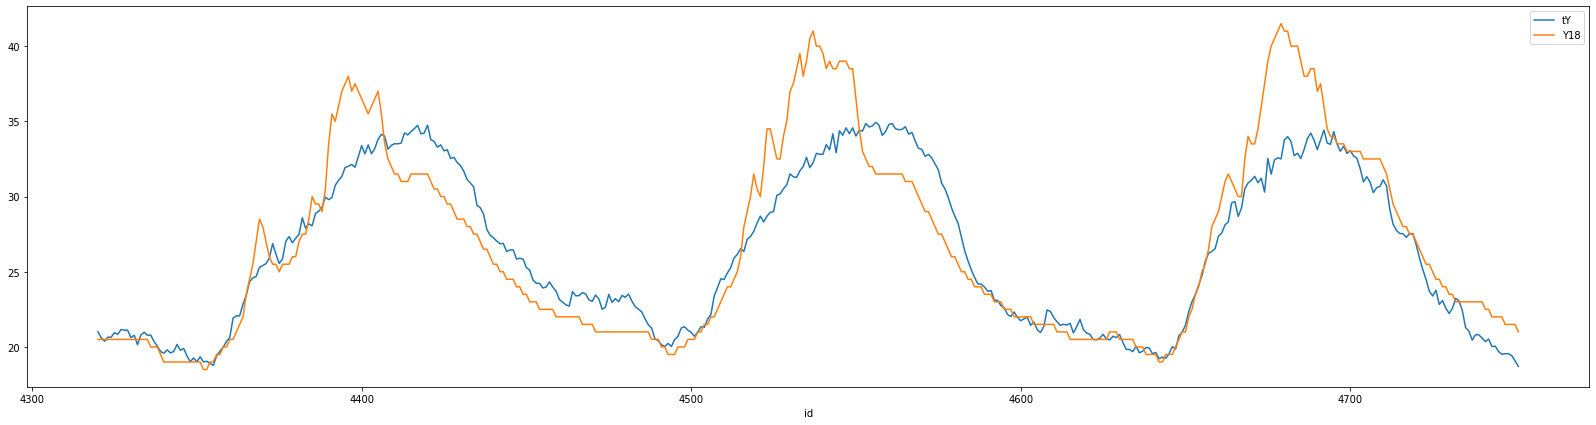

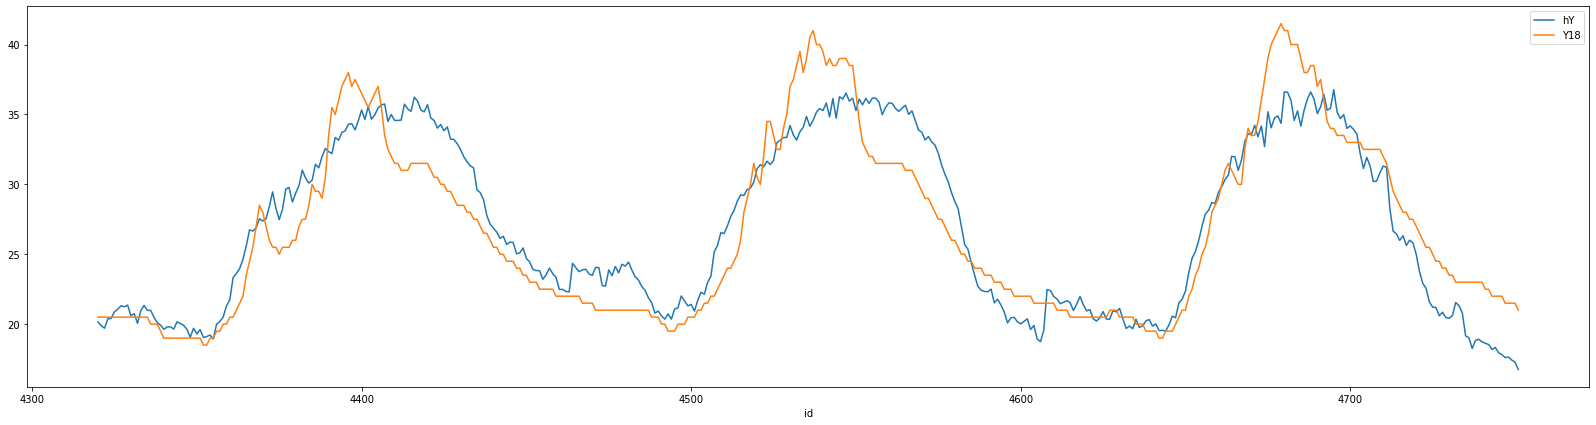

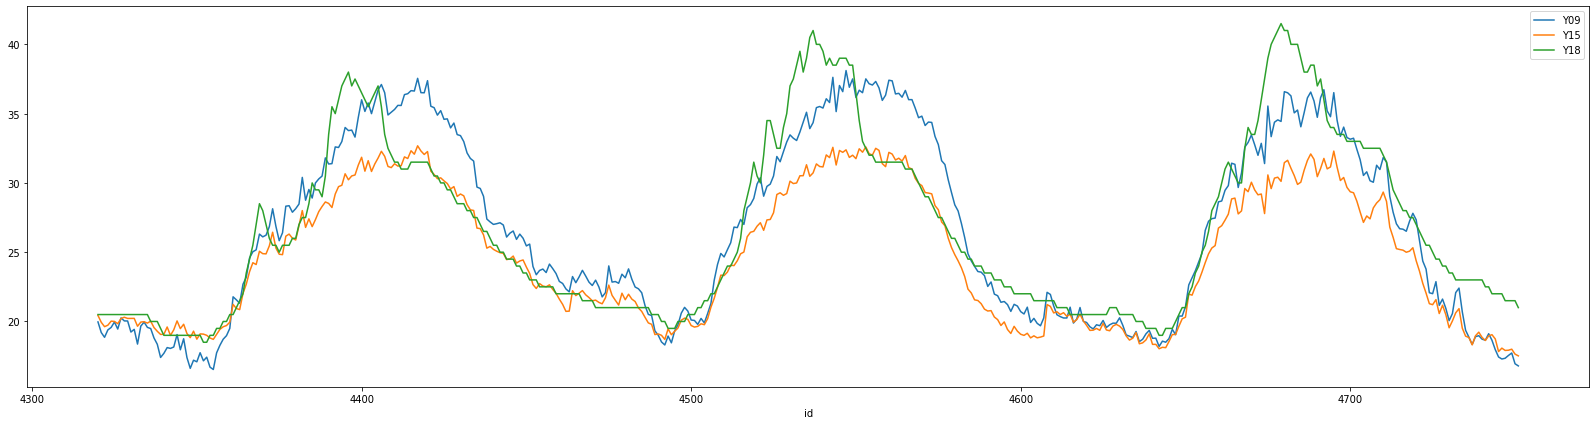

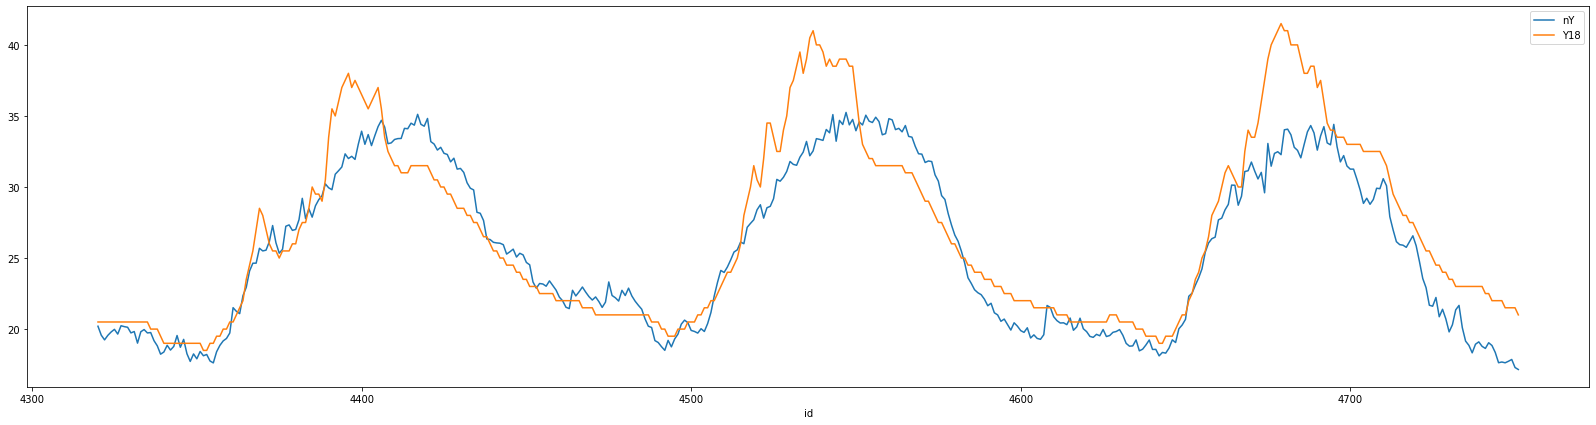

In [27]:
Y_val.plot(x='id', y=['tY', 'Y18'], figsize=(28,7))
Y_val.plot(x='id', y=['hY', 'Y18'], figsize=(28,7))
Y_val.plot(x='id', y=['Y09', 'Y15', 'Y18'], figsize=(28,7))
Y_val.plot(x='id', y=['nY', 'Y18'], figsize=(28,7))

In [28]:
Y_val[Y_cols + ['Y18']].corr()

Y00       Y01       Y02  ...       Y16       Y17       Y18
Y00  1.000000  0.954402  0.961240  ...  0.744063  0.765616  0.731099
Y01  0.954402  1.000000  0.998238  ...  0.895839  0.912228  0.852247
Y02  0.961240  0.998238  1.000000  ...  0.890473  0.906154  0.854433
Y03  0.938879  0.809511  0.819216  ...  0.482099  0.512996  0.497805
Y04  0.938348  0.809231  0.818661  ...  0.480984  0.512316  0.495583
Y05  0.844066  0.959772  0.953968  ...  0.975982  0.987398  0.901575
Y06  0.563304  0.754235  0.749383  ...  0.957707  0.938691  0.860917
Y07  0.495638  0.687953  0.686248  ...  0.907869  0.898079  0.828583
Y08  0.887195  0.977718  0.972150  ...  0.944275  0.963790  0.879993
Y09  0.819047  0.946718  0.941489  ...  0.982502  0.992934  0.914207
Y10  0.852172  0.966735  0.960511  ...  0.967069  0.981804  0.901926
Y11  0.843982  0.962128  0.956623  ...  0.971486  0.985851  0.907514
Y12  0.565335  0.756864  0.751905  ...  0.960376  0.937793  0.875392
Y13  0.909908  0.987349  0.983318  ...  0.939375  0.954969  0.881114
Y14  0.934738  0.989567  0.983358  ...  0.898893  0.915822  0.838492
Y15  0.793377  0.925352  0.922482  ...  0.983021  0.991820  0.919759
Y16  0.744063  0.895839  0.890473  ...  1.000000  0.987478  0.914670
Y17  0.765616  0.912228  0.906154  ...  0.987478  1.000000  0.910331
Y18  0.731099  0.852247  0.854433  ...  0.914670  0.910331  1.000000

[19 rows x 19 columns]

In [43]:
Y_val[Y_cols + ['Y18']].corr()['Y18'] >= 0.90

Y00    False
Y01    False
Y02    False
Y03    False
Y04    False
Y05     True
Y06    False
Y07    False
Y08    False
Y09     True
Y10     True
Y11     True
Y12    False
Y13    False
Y14    False
Y15     True
Y16     True
Y17     True
Y18     True
Name: Y18, dtype: bool

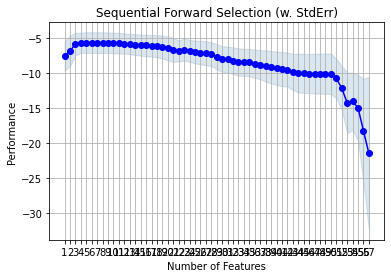

feature_names: ('minute', 'X26', 'X36', 'X38', 'Y06', 'Y12', 'Y15'), avg_score: -5.665437207909138


In [30]:
sfs = forward_selection(Ridge(alpha=1.0), val, X_cols + Y_cols, 'Y18')
features = print_good_features(sfs)

### LinearRegression을 이용한 forward Seletion

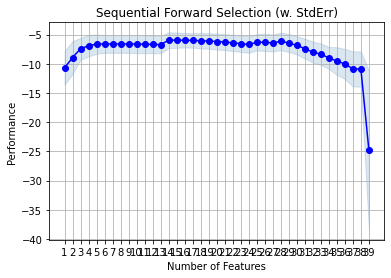

feature_names: ('minute', 'X02', 'X04', 'X05', 'X12', 'X17', 'X22', 'X23', 'X26', 'X29', 'X30', 'X35', 'X36', 'X38'), avg_score: -5.948689140058327


In [31]:
sfs = forward_selection(LinearRegression(), val, X_cols)
features = print_good_features(sfs)

In [32]:
lr_feature_name = list(features)
check_cross_val_score(LinearRegression(), val, lr_feature_name)

Accuracy: 0.73 (+/- 0.34)


### Ridge을 이용한 forward Seletion

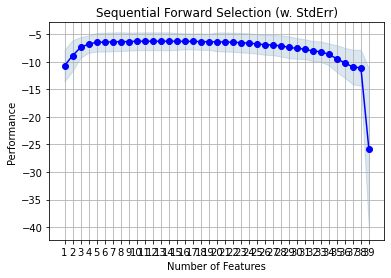

feature_names: ('X05', 'X06', 'X08', 'X12', 'X22', 'X23', 'X29', 'X30', 'X35', 'X36', 'X37', 'X38'), avg_score: -6.303022288469515


In [33]:
sfs = forward_selection(Ridge(alpha=1.0), val, X_cols)
features = print_good_features(sfs)

In [34]:
ridge_feature_name = list(features)
check_cross_val_score(Ridge(alpha=1.0), val, ridge_feature_name)

Accuracy: 0.74 (+/- 0.19)


### Univariate Selection
- Ref: https://wikidocs.net/16599

In [35]:
from sklearn.feature_selection import SelectKBest, f_classif

selectK = SelectKBest(score_func=f_classif, k=8)
X = selectK.fit_transform(val[X_cols], val['Y18'])

selectK_feature_name = list()

for col in X_cols:
  if list(val[col])[0] in X[0]:
    print("'{}'".format(col), end=", ")
    selectK_feature_name.append(col)
print()

'X00', 'X07', 'X12', 'X20', 'X30', 'X31', 'X32', 'X37', 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 6 35] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Feature Importance

In [36]:
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, 8)
fit = rfe.fit(val[X_cols], val['Y18'])

rfe_feature_name = np.array(X_cols)[fit.support_]

print(f"Num Features: {fit.n_features_}")
print(f"Selected Features: {np.array(X_cols)[fit.support_]}")
print(f"Feature Ranking: {np.array(X_cols)[fit.ranking_]}")

Num Features: 8
Selected Features: ['X01' 'X06' 'X08' 'X09' 'X27' 'X29' 'X33' 'X39']
Feature Ranking: ['X03' 'X21' 'X18' 'minute' 'X10' 'X28' 'X32' 'X01' 'minute' 'X22'
 'minute' 'minute' 'X11' 'X05' 'X25' 'X29' 'X30' 'X31' 'X12' 'X20' 'X17'
 'X00' 'X02' 'X24' 'X27' 'X08' 'minute' 'X13' 'minute' 'X15' 'X07' 'X23'
 'minute' 'X04' 'X26' 'X33' 'X06' 'X09' 'minute']


### recursive feature elimination
- 재귀적으로 특징 제거
- 시간이 오래 걸린다

In [0]:
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVR
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(val[X_cols], val['Y18'])

# print(f"Selected Features: {np.array(X_cols)[selector.support_]}")
# print(f"Feature Ranking: {np.array(X_cols)[selector.ranking_]}")

### Model Selection

In [0]:
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# pipe = Pipeline([('classifier', LogisticRegression())])

# param_grid = [{'classifier': [SVR()], 
#               'classifier__gamma': [0.01, 0.1, 1, 10, 100], 
#               'classifier__C': [0.01, 0.1, 1, 10, 100]
#               },

#                {'classifier': [LogisticRegression()],
#                'classifier__penalty': ['l1', 'l2'], 
#                'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
#                },

#               {'classifier': [RandomForestClassifier()],
#               'classifier__max_depth': [4, 6], # max_depth: The maximum depth of the tree.
#               'classifier__n_estimators': [50, 100], # n_estimators: The number of trees in the forest.
#               'classifier__min_samples_split': [50, 100]
#               }] # min_samples_split: The minimum number of samples required to split an internal node       

# grid = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=5)  
# grid.fit(val[X_cols], val['Y18'])

# print(grid.best_params_)
# print(grid.best_score_)

In [44]:
list(np.array(Y_cols + ['Y18'])[Y_val[Y_cols + ['Y18']].corr()['Y18'] >= 0.9])

['Y05', 'Y09', 'Y10', 'Y11', 'Y15', 'Y16', 'Y17', 'Y18']

In [49]:
for name, features in feature_names.items():
  print(name, features)

lr ['minute', 'X02', 'X04', 'X05', 'X12', 'X17', 'X22', 'X23', 'X26', 'X29', 'X30', 'X35', 'X36', 'X38']
ridge ['X05', 'X06', 'X08', 'X12', 'X22', 'X23', 'X29', 'X30', 'X35', 'X36', 'X37', 'X38']
selectK ['X00', 'X07', 'X12', 'X20', 'X30', 'X31', 'X32', 'X37']
rfe ['X01' 'X06' 'X08' 'X09' 'X27' 'X29' 'X33' 'X39']


In [0]:
feature_names = {'lr': lr_feature_name,
                 'ridge': ridge_feature_name,
                 'selectK' : selectK_feature_name,
                 'rfe' : rfe_feature_name}

In [0]:
# # 5,6,7,8,11, 12
# 'X04', 'X26', 'X36', 'X38', 'Y06', 'Y12', 'Y15'

target_Y_cols = list(np.array(Y_cols + ['Y18'])[Y_val[Y_cols + ['Y18']].corr()['Y18'] >= 0.9]) + ['hY']
# hY : Y_val['hY'] = Y_val[['Y05', 'Y07', 'Y08', 'Y12', 'Y17']].mean(axis=1)
train['hY'] = train[['Y05', 'Y07', 'Y08', 'Y12', 'Y17']].mean(axis=1)

In [0]:
target_Y_cols = ['Y09', 'Y17']

In [47]:
# train['Y18'] = train[Y_cols].mean(axis=1)
total_train = pd.DataFrame(columns=X_cols + ["Y18"])

for Y_col in target_Y_cols:
  temp = train[X_cols + [Y_col]]
  temp.rename(columns={Y_col: 'Y18'}, inplace=True)

  total_train = pd.concat([total_train, temp], axis=0)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
total_train

hour minute   X00    X01  X02  ...  X36   X37   X38  X39   Y18
0      0.000000      0   9.7  988.8  1.2  ...  0.0  77.2  62.6  0.0   7.0
1      0.166667      1   9.3  988.9  1.7  ...  0.0  77.3  63.5  0.0   6.5
2      0.333333      2   9.4  989.0  1.1  ...  0.0  77.3  63.9  0.0   6.5
3      0.500000      3   9.4  988.9  1.5  ...  0.0  77.5  64.5  0.0   6.0
4      0.666667      4   9.2  988.9  0.8  ...  0.0  78.0  65.0  0.0   6.0
...         ...    ...   ...    ...  ...  ...  ...   ...   ...  ...   ...
4315  23.166667      1  19.5  987.8  1.7  ...  0.0  82.3  74.3  0.0  20.0
4316  23.333333      2  19.3  987.7  2.1  ...  0.0  82.4  74.8  0.0  19.5
4317  23.500000      3  19.5  987.8  0.9  ...  0.0  82.8  75.4  0.0  19.0
4318  23.666667      4  20.0  987.8  1.4  ...  0.0  82.8  75.8  0.0  19.0
4319  23.833333      5  20.1  987.8  1.2  ...  0.0  83.5  76.9  0.0  19.0

[8640 rows x 40 columns]

In [0]:
total_train['minute'].dtype('int')

In [0]:
total_train['minute'] = total_train['minute'].astype('int')

In [62]:
total_train['minute'].dtype

dtype('int64')

### lightbgm으로 예측하기

In [0]:
def train_lgb(dataset, X_cols, Y_col='Y18'):
    lgb_train = lgb.Dataset(dataset[X_cols], label=dataset[Y_col])

    lgb_param = {
        'objective': 'regression',
        'metrics': 'mae',
        'learning_rate' : 0.01
    }

    cv_result = lgb.cv(
        lgb_param,
        lgb_train,
        num_boost_round=99999,
        nfold = 5,
        early_stopping_rounds=10,
        stratified=False,
        verbose_eval=10
    )

    lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result['l1-mean'])
    )

    return lgb_model

def get_val_accuracy(clf, X_cols, Y_col='Y18'):
  pred = clf.predict(val[X_cols])
  mae = mean_absolute_error(val[Y_col], pred)

  return mae

def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return score

In [64]:
results = dict()

for name, features in feature_names.items():
  lgb_model = train_lgb(total_train, features)

  pred = lgb_model.predict(val[features])
  val_accuracy = mse_AIFrenz(val['Y18'], pred)

  # val_accuracy = get_val_accuracy(lgb_model, features)

  print(f"feature_name: {name}, val_accracy: {val_accuracy} =====================")
  results[name] = val_accuracy

[10]	cv_agg's l1: 7.30064 + 0.0856732
[20]	cv_agg's l1: 6.70711 + 0.0815751
[30]	cv_agg's l1: 6.18264 + 0.0754425
[40]	cv_agg's l1: 5.71628 + 0.0693084
[50]	cv_agg's l1: 5.30294 + 0.0634031
[60]	cv_agg's l1: 4.94078 + 0.0581806
[70]	cv_agg's l1: 4.62323 + 0.0516967
[80]	cv_agg's l1: 4.34596 + 0.044712
[90]	cv_agg's l1: 4.10037 + 0.038142
[100]	cv_agg's l1: 3.88535 + 0.0328844
[110]	cv_agg's l1: 3.69694 + 0.0304009
[120]	cv_agg's l1: 3.53184 + 0.0291066
[130]	cv_agg's l1: 3.38963 + 0.0277965
[140]	cv_agg's l1: 3.26628 + 0.0271515
[150]	cv_agg's l1: 3.15895 + 0.026786
[160]	cv_agg's l1: 3.06368 + 0.0263874
[170]	cv_agg's l1: 2.97985 + 0.0256839
[180]	cv_agg's l1: 2.90489 + 0.0251294
[190]	cv_agg's l1: 2.83732 + 0.0249389
[200]	cv_agg's l1: 2.77673 + 0.0245159
[210]	cv_agg's l1: 2.72335 + 0.0228801
[220]	cv_agg's l1: 2.67574 + 0.0221658
[230]	cv_agg's l1: 2.63244 + 0.0224099
[240]	cv_agg's l1: 2.59259 + 0.0228904
[250]	cv_agg's l1: 2.5554 + 0.0231841
[260]	cv_agg's l1: 2.52217 + 0.0239244

In [65]:
max_name = None

for name, accuracy in sorted(results.items(), key=lambda x: x[1]):
  if max_name is None : max_name = name
  print(f"feature_name: {name}, val_accracy: {accuracy}")

feature_name: selectK, val_accracy: 11.086468027742733
feature_name: rfe, val_accracy: 18.77421731260383
feature_name: lr, val_accracy: 23.83785135014062
feature_name: ridge, val_accracy: 23.95014884627618


In [66]:
results2 = dict()

for name, features in feature_names.items():
  clf = Ridge(alpha=1.0)
  clf.fit(total_train[features], total_train['Y18'])

  pred = clf.predict(val[features])
  val_accuracy = mse_AIFrenz(val['Y18'], pred)

  # val_accuracy = get_val_accuracy(lgb_model, features)

  print(f"feature_name: {name}, val_accracy: {val_accuracy}")
  results2[name] = val_accuracy

feature_name: lr, val_accracy: 18.065558893814885
feature_name: ridge, val_accracy: 12.668890543905134
feature_name: selectK, val_accracy: 8.410689480745534
feature_name: rfe, val_accracy: 9.260825294043743


In [67]:
max_name2 = None

for name, accuracy in sorted(results2.items(), key=lambda x: x[1]):
  if max_name2 is None : max_name2 = name
  print(f"feature_name: {name}, val_accracy: {accuracy}")

feature_name: selectK, val_accracy: 8.410689480745534
feature_name: rfe, val_accracy: 9.260825294043743
feature_name: ridge, val_accracy: 12.668890543905134
feature_name: lr, val_accracy: 18.065558893814885


In [68]:
clf = Ridge(alpha=1.0)
clf.fit(total_train[X_cols], total_train['Y18'])

pred = clf.predict(val[X_cols])
val_accuracy = mse_AIFrenz(val['Y18'], pred)

print(f"feature_name: all, val_accracy: {val_accuracy}")

feature_name: all, val_accracy: 6.035863995832771


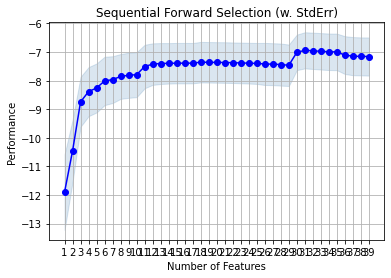

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X23', 'X24', 'X25', 'X26', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'), avg_score: -6.9389711317746245
feature: ['hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X23', 'X24', 'X25', 'X26', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'], mse:6.240822072486285


In [69]:
sfs = forward_selection(Ridge(alpha=1.0), total_train, X_cols)
features = print_good_features(sfs)

ridge_feature_name = list(features)

ridge = Ridge(alpha=1.0).fit(total_train[ridge_feature_name], total_train['Y18'])
mse = mse_AIFrenz(val['Y18'], ridge.predict(val[ridge_feature_name]))

print(f"feature: {ridge_feature_name}, mse:{mse}")

In [70]:
len(ridge_feature_name), len(X_cols)

(31, 39)

In [78]:
total_train

hour  minute   X00    X01  X02  X03  ...    X35  X36   X37   X38  X39   Y18
0        0       0   9.7  988.8  1.2  0.6  ...  256.4  0.0  77.2  62.6  0.0   7.0
1        0       1   9.3  988.9  1.7  1.9  ...  215.4  0.0  77.3  63.5  0.0   6.5
2        0       2   9.4  989.0  1.1  2.3  ...  235.2  0.0  77.3  63.9  0.0   6.5
3        0       3   9.4  988.9  1.5  0.7  ...  214.0  0.0  77.5  64.5  0.0   6.0
4        0       4   9.2  988.9  0.8  1.7  ...  174.9  0.0  78.0  65.0  0.0   6.0
...    ...     ...   ...    ...  ...  ...  ...    ...  ...   ...   ...  ...   ...
4315    23       1  19.5  987.8  1.7  0.4  ...  272.9  0.0  82.3  74.3  0.0  20.0
4316    23       2  19.3  987.7  2.1  0.9  ...  315.9  0.0  82.4  74.8  0.0  19.5
4317    23       3  19.5  987.8  0.9  1.3  ...  343.3  0.0  82.8  75.4  0.0  19.0
4318    23       4  20.0  987.8  1.4  0.5  ...  341.7  0.0  82.8  75.8  0.0  19.0
4319    23       5  20.1  987.8  1.2  1.2  ...  326.4  0.0  83.5  76.9  0.0  19.0

[8640 rows x 40 columns]

ERROR! Session/line number was not unique in database. History logging moved to new session 60


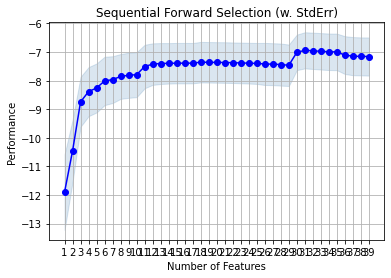

feature_names: ('hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X23', 'X24', 'X25', 'X26', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'), avg_score: -6.9389711317746245
feature: ['hour', 'minute', 'X00', 'X02', 'X03', 'X06', 'X07', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X23', 'X24', 'X25', 'X26', 'X28', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'], mse:6.240822072486285


In [76]:
sfs = forward_selection(Ridge(alpha=1.0), total_train, X_cols)
features = print_good_features(sfs)

ridge_feature_name = list(features)

ridge = Ridge(alpha=1.0).fit(total_train[ridge_feature_name], total_train['Y18'])
mse = mse_AIFrenz(val['Y18'], ridge.predict(val[ridge_feature_name]))

print(f"feature: {ridge_feature_name}, mse:{mse}")

In [0]:
X = ['hour'] + feature_names['selectK']

In [109]:
feature_names['selectK']

['X00', 'X07', 'X12', 'X20', 'X30', 'X31', 'X32', 'X37']

In [0]:
total_data = pd.concat([total_train, val], axis=0)

In [0]:
total_data['hour'] = total_data['hour'].astype('int')
total_data['minute'] = total_data['minute'].astype('int')


In [104]:
clf = Ridge(alpha=1.0)
clf.fit(total_data[X], total_data['Y18'])

pred = clf.predict(val[X])
val_accuracy = mse_AIFrenz(val['Y18'], pred)

print(val_accuracy)

7.873509012387098


In [107]:
total_data[X]

hour   X00   X07   X12   X20   X30   X31   X32   X37
0        0   9.7  12.2  82.4  91.0  69.1   8.2  10.7  77.2
1        0   9.3  12.1  81.2  91.9  70.3   8.3  10.3  77.3
2        0   9.4  12.1  86.1  93.3  71.5   8.0   9.7  77.3
3        0   9.4  12.0  87.7  93.4  73.2   7.7   9.4  77.5
4        0   9.2  12.0  88.9  94.1  74.3   7.4   9.4  78.0
...    ...   ...   ...   ...   ...   ...   ...   ...   ...
4747    23  19.9  21.7  95.3  89.7  89.9  17.7  19.1  82.3
4748    23  19.9  21.6  95.6  90.1  91.3  17.7  19.2  82.5
4749    23  19.7  21.4  95.9  90.8  90.2  17.8  19.2  83.0
4750    23  19.4  21.3  95.9  91.5  90.1  17.7  19.3  83.2
4751    23  19.1  21.2  96.2  93.0  89.6  17.7  19.5  84.0

[9072 rows x 9 columns]

In [108]:
submit(Ridge(alpha=1.0).fit(total_data[X], total_data['Y18']), X, "ridge_9_17Y=Y18")

hour   X00   X07   X12   X20   X30   X31   X32   X37
0         0  18.7  21.1  96.1  94.7  91.4  17.5  19.2  84.0
1         0  18.8  21.2  96.2  95.3  91.6  17.4  19.1  84.0
2         0  19.0  21.2  96.4  93.9  92.0  17.2  19.0  85.0
3         0  18.7  21.1  96.5  94.4  93.0  17.2  18.8  85.8
4         0  18.4  20.9  96.6  95.7  92.3  17.4  18.9  87.3
...     ...   ...   ...   ...   ...   ...   ...   ...   ...
11515    23  25.7  26.3  88.1  77.3  76.6  23.6  24.4  79.7
11516    23  25.6  26.3  75.5  78.1  76.7  25.3  24.4  79.6
11517    23  25.6  26.2  77.5  78.9  77.1  24.9  24.3  79.2
11518    23  25.5  26.1  74.1  79.7  77.3  25.3  24.2  80.1
11519    23  25.4  26.0  73.3  80.6  76.6  25.4  24.3  80.2

[11520 rows x 9 columns]

[19.95564209 19.9161768  19.98539461 ... 27.3085432  27.49386095
 27.57239518]


### Submit

In [0]:
def submit(clf, X_cols, name="None"):
  submit = pd.read_csv(base + 'sample_submission.csv')
  test = pd.read_csv(base + "test.csv")
  test['hour'] = (test.index % 144 / 6).astype('int')
  test['minute'] = (test.index % 144 % 6).astype('int')
  display(test[X_cols])

  pred = clf.predict(test[X_cols])
  print(pred)

  submit['Y18'] = pred

  submit.to_csv(os.path.join(base, "제출", name + ".csv"), index=None)

In [0]:
# total_data = pd.concat([train, val], axis=0)
total_data = pd.concat([total_train, val], axis=0)

### Ridge

In [0]:
ridge = Ridge(alpha=1.0)
ridge.fit(total_data[ridge_feature_name], total_data['Y18'])
submit(ridge, ridge_feature_name, "ridge_someY=Y18")

### lightbgm

In [0]:
lgb_model = train_lgb(total_data, feature_names[max_name])
submit(lgb_model, feature_names[max_name], "good_EDA_lightbgm")